In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from cleanlab.count import compute_confident_joint
import seaborn as sns
import matplotlib.pyplot as plt

PREDICTIONS_PATH = Path("/workspace/cv_folds_5fold/predictions_11_Dec")
CLASS_NAMES = ['knife', 'gun', 'rifle', 'baseball_bat', 'background']
NUM_CLASSES = 5

/workspace/yolo_dangerous_weapons/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(PREDICTIONS_PATH / "all_predictions.pkl", "rb") as f:
    all_predictions = pickle.load(f)

print(f"Total images: {len(all_predictions)}")

Total images: 17490


In [3]:
def get_primary_class(gt_boxes):
    if not gt_boxes:
        return 4
    classes = [b['class_id'] for b in gt_boxes]
    return max(set(classes), key=classes.count)

def get_pred_probs(pred_boxes, num_classes=5):
    probs = np.zeros(num_classes)
    if not pred_boxes:
        probs[4] = 1.0
        return probs
    for box in pred_boxes:
        cls_id = box['class_id']
        conf = box['confidence']
        probs[cls_id] = max(probs[cls_id], conf)
    if probs[:4].sum() == 0:
        probs[4] = 1.0
    else:
        probs[4] = max(0, 1.0 - probs[:4].max())
    probs = probs / probs.sum()
    return probs

In [4]:
labels = []
pred_probs = []
image_paths = []

for img_path, data in all_predictions.items():
    label = get_primary_class(data['ground_truth'])
    probs = get_pred_probs(data['predictions'], NUM_CLASSES)
    labels.append(label)
    pred_probs.append(probs)
    image_paths.append(img_path)

labels = np.array(labels)
pred_probs = np.array(pred_probs)

print(f"Labels shape: {labels.shape}")
print(f"Pred probs shape: {pred_probs.shape}")
print(f"\nLabel distribution:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {(labels == i).sum()}")

Labels shape: (17490,)
Pred probs shape: (17490, 5)

Label distribution:
  knife: 3282
  gun: 5708
  rifle: 3426
  baseball_bat: 1542
  background: 3532


In [5]:
confident_joint, off_diag_indices = compute_confident_joint(
    labels=labels,
    pred_probs=pred_probs,
    calibrate=True,
    return_indices_of_off_diagonals=True
)

print("Confident Joint Matrix:")
print(confident_joint)
print(f"\nOff-diagonal examples (potential label errors): {len(off_diag_indices)}")

Confident Joint Matrix:
[[3204    5   22    4   47]
 [   4 5562   24    1  117]
 [   1   29 3333    1   62]
 [   7    1    2 1504   28]
 [   1    5    0    1 3525]]

Off-diagonal examples (potential label errors): 274


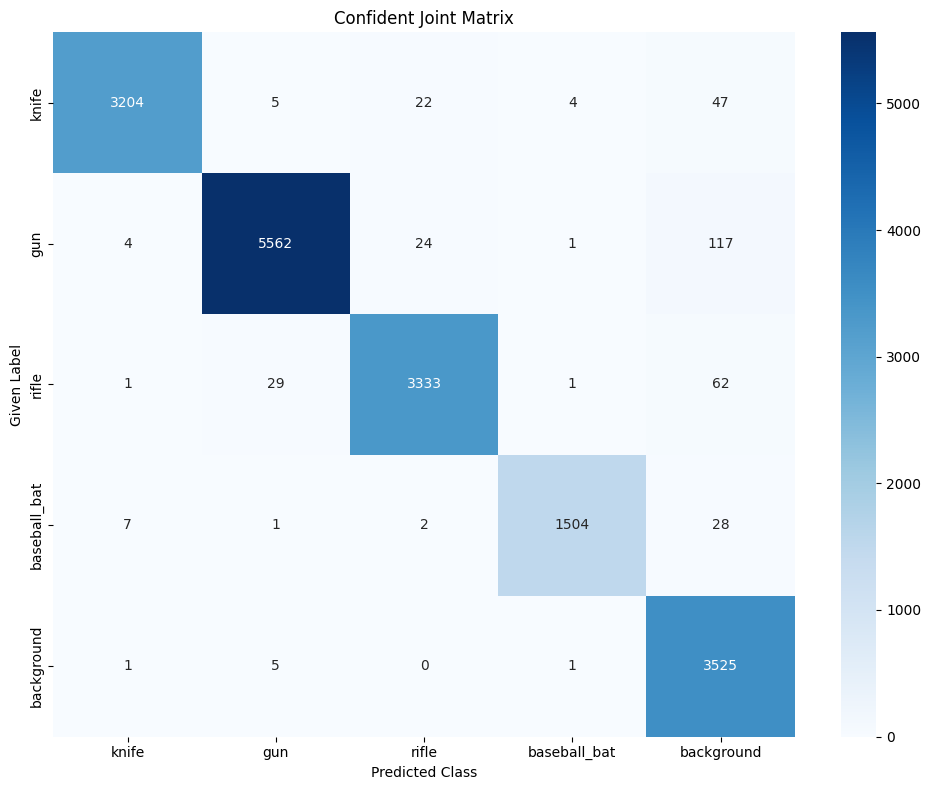

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    confident_joint,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel('Predicted Class')
plt.ylabel('Given Label')
plt.title('Confident Joint Matrix')
plt.tight_layout()
plt.savefig(PREDICTIONS_PATH / 'confident_joint.png', dpi=150)
plt.show()

In [7]:
error_candidates = []
for idx in off_diag_indices:
    given_label = labels[idx]
    pred_label = np.argmax(pred_probs[idx])
    pred_conf = pred_probs[idx][pred_label]
    error_candidates.append({
        'image_path': image_paths[idx],
        'given_label': CLASS_NAMES[given_label],
        'predicted_label': CLASS_NAMES[pred_label],
        'predicted_conf': pred_conf,
        'given_label_id': given_label,
        'predicted_label_id': pred_label
    })

errors_df = pd.DataFrame(error_candidates)
errors_df = errors_df.sort_values('predicted_conf', ascending=False)
print(f"Total potential label errors: {len(errors_df)}")
errors_df.head(20)

Total potential label errors: 274


,image_path,given_label,predicted_label,predicted_conf,given_label_id,predicted_label_id
273,/workspace/cv_folds_5fold/fold_4/images/val/vo...,knife,background,1.0,0,4
167,/workspace/cv_folds_5fold/fold_3/images/val/da...,baseball_bat,background,1.0,3,4
100,/workspace/cv_folds_5fold/fold_2/images/val/da...,baseball_bat,background,1.0,3,4
99,/workspace/cv_folds_5fold/fold_2/images/val/vo...,gun,background,1.0,1,4
98,/workspace/cv_folds_5fold/fold_2/images/val/da...,baseball_bat,background,1.0,3,4
195,/workspace/cv_folds_5fold/fold_4/images/val/yo...,rifle,background,1.0,2,4
96,/workspace/cv_folds_5fold/fold_1/images/val/vo...,gun,background,1.0,1,4
95,/workspace/cv_folds_5fold/fold_1/images/val/yo...,rifle,background,1.0,2,4
94,/workspace/cv_folds_5fold/fold_1/images/val/da...,baseball_bat,background,1.0,3,4
242,/workspace/cv_folds_5fold/fold_4/images/val/vo...,gun,background,1.0,1,4


In [8]:
errors_df.to_csv(PREDICTIONS_PATH / 'label_errors.csv', index=False)
np.save(PREDICTIONS_PATH / 'confident_joint.npy', confident_joint)

print(f"Saved: {PREDICTIONS_PATH / 'label_errors.csv'}")
print(f"Saved: {PREDICTIONS_PATH / 'confident_joint.npy'}")

print("\nError breakdown by type:")
print(errors_df.groupby(['given_label', 'predicted_label']).size().sort_values(ascending=False))

Saved: /workspace/cv_folds_5fold/predictions_11_Dec/label_errors.csv
Saved: /workspace/cv_folds_5fold/predictions_11_Dec/confident_joint.npy

Error breakdown by type:
given_label   predicted_label
gun           background         88
rifle         background         48
knife         background         35
rifle         gun                22
baseball_bat  background         21
gun           rifle              18
knife         rifle              16
baseball_bat  knife               5
knife         gun                 4
background    gun                 4
gun           knife               3
knife         baseball_bat        3
rifle         baseball_bat        1
background    baseball_bat        1
gun           baseball_bat        1
baseball_bat  rifle               1
              gun                 1
background    knife               1
rifle         knife               1
dtype: int64


In [9]:
import shutil

INSPECTION_PATH = Path("/workspace/cv_folds_5fold/label_errors_inspection")
if INSPECTION_PATH.exists():
    shutil.rmtree(INSPECTION_PATH)
INSPECTION_PATH.mkdir(parents=True)

for _, row in errors_df.iterrows():
    img_path = Path(row['image_path'])
    folder_name = f"labeled_{row['given_label']}_pred_{row['predicted_label']}"
    folder = INSPECTION_PATH / folder_name
    folder.mkdir(exist_ok=True)
    
    label_path = img_path.parent.parent / 'labels' / 'val' / f"{img_path.stem}.txt"
    
    shutil.copy2(img_path, folder / img_path.name)
    if label_path.exists():
        shutil.copy2(label_path, folder / label_path.name)

print(f"Organized {len(errors_df)} images into: {INSPECTION_PATH}")
for folder in sorted(INSPECTION_PATH.iterdir()):
    count = len(list(folder.glob('*.jpg'))) + len(list(folder.glob('*.png')))
    print(f"  {folder.name}: {count} images")

Organized 274 images into: /workspace/cv_folds_5fold/label_errors_inspection
  labeled_background_pred_baseball_bat: 1 images
  labeled_background_pred_gun: 4 images
  labeled_background_pred_knife: 1 images
  labeled_baseball_bat_pred_background: 21 images
  labeled_baseball_bat_pred_gun: 1 images
  labeled_baseball_bat_pred_knife: 5 images
  labeled_baseball_bat_pred_rifle: 1 images
  labeled_gun_pred_background: 88 images
  labeled_gun_pred_baseball_bat: 1 images
  labeled_gun_pred_knife: 3 images
  labeled_gun_pred_rifle: 18 images
  labeled_knife_pred_background: 35 images
  labeled_knife_pred_baseball_bat: 3 images
  labeled_knife_pred_gun: 4 images
  labeled_knife_pred_rifle: 16 images
  labeled_rifle_pred_background: 48 images
  labeled_rifle_pred_baseball_bat: 1 images
  labeled_rifle_pred_gun: 22 images
  labeled_rifle_pred_knife: 1 images
